# Models

In [21]:
'''IMPORT THE LIBRARIES'''
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors.kde import KernelDensity

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

from time import clock

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

from collections import defaultdict

## Modeling Longitudinal Component of the Data

As previously discussed, in the development of a predictive model based on medical studies, one of the key challenges is the longitudinal component of the data. In the ADNI study, patients have multiple entries in the database, each one corresponding to a different visit. One has to take into account this progression over time in order predict future data.

Let us recall the objective of the project: predict over time CDRSB score and diagnosis.

### Progression of CDRSB over Time

We can plot the progression of the CDRSB score over time for a subset of patients.

In [2]:
'''LOAD THE DATABASE'''
f = 'ADNIDataFiles/ADNIMERGE.csv'
df = pd.read_csv(f)

In [3]:
'''CLEAN THE DATABASE'''

# Work on a copy of the raw df
df_dummy = df.copy()

#Create a new cleaned df
df_clean = pd.DataFrame()

#Diagnosis
df_clean['Diagnosis'] = df_dummy.DX.replace({'Dementia':'AD'})

#CDRSB
df_clean['CDRSB'] = df_dummy.CDRSB

#Patient ID
df_clean['ID'] = pd.Categorical(df_dummy.PTID)
df_clean.ID = df_clean.ID.cat.codes

#Age at each visit
df_dummy.EXAMDATE = pd.to_datetime(df_dummy['EXAMDATE'])
df_dummy['FIRSTDATE'] = df_dummy.groupby('PTID')['EXAMDATE'].transform(min)
df_dummy['TIMESINCEFIRST'] = (df_dummy.EXAMDATE - df_dummy.FIRSTDATE).dt.days
df_clean['AGE'] = df_dummy.AGE + df_dummy.TIMESINCEFIRST/365.
df_clean['TIME'] = df_dummy.TIMESINCEFIRST/365

#Gender one-hot encoding on female
df_clean['Female'] = pd.get_dummies(df_dummy.PTGENDER)['Female']

#Education years
df_clean['Education'] = df_dummy.PTEDUCAT

#Ethicity one-hot encoding on unknown
df_clean[['Hispanic','Non_Hispanic']] = pd.get_dummies(df_dummy.PTETHCAT)[['Hisp/Latino','Not Hisp/Latino']]

#Race as categorical data
df_clean['Race'] = pd.Categorical(df_dummy.PTRACCAT)

#Race as categorical data
df_clean['Marital_status'] = pd.Categorical(df_dummy.PTMARRY)

#Gene APOE4 (Important gene with different types)
df_clean['APOE4'] = pd.Categorical(df_dummy.APOE4)

#FDG (PET scan marker)
# df_clean['FDG'] = df_dummy.FDG

#Create a list of predictors for which we want to calculate delta
# REMOVE SOFTWARE AND FIELD STRENGHT
remainingColumns = ['ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA',
 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan',
 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat',
 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal',
 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
 'Fusiform', 'MidTemp', 'ICV']

for c in remainingColumns:
    df_clean[c] = df_dummy[c]
    
df_clean = df_clean[pd.notna(df_clean['CDRSB'])]

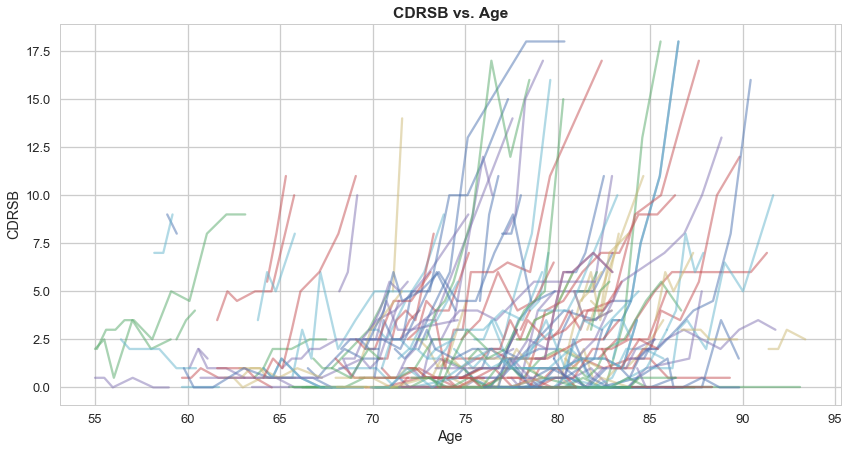

In [4]:
'''PROGRESSION OF CDRSB'''

#Line plot CDRSB vs Age by patient
fig, ax = plt.subplots(figsize=(14,7))
grouped = df_clean.sort_values(by=['AGE']).groupby('ID')

#Select a subset of patient
n_patients = 200
for i in df_clean['ID'].sample(n_patients):
    grouped.get_group(i).plot(x='AGE',y='CDRSB', ax=ax, legend=False, alpha=0.5)

plt.xlabel('Age')
plt.ylabel('CDRSB')
plt.title('CDRSB vs. Age',fontweight='bold');

From the plot above, we assume linear relationship between patient age and CDRSB score. The CDRSB score over time is simply

\begin{equation}
CDRSB(t) = mt + CDRSB_0,
\end{equation}

where $t$ is time, $m$ is the slope, and $CDRSB_0$ is the baseline score.

### New Response Variable: CDRSB Slope

To remove the longitudinal component of the data, we engineer the features $m = \texttt{slope_overall}$ as well as $m_i = \texttt{slope}_i$ where $i$ correspond to the $i$-th year since baseline. The response variable becomes $\texttt{slope_overall}$ and the CDRSB score is predicted based on the formula above. Finally, the diagnosis is predicted from the classifier discussed in the EDA

* CDRSB $< .5$: Final diagnosis is CN
* $0.5 \le$ CDRSB$ < 4.0$: Final diagnosis is MCI
* CDRSB$\ge 4.0$: Final diagnosis is AD

### Feature Engineering

First, we add the new features to the main dataframe. In addition to computing the overall CDRSB slope, we also compute an incremental slope estimate at each visit for each patient.

In [5]:
'''FEATURE ENGINEERING'''

#Sort and group to compute current slopes
grouped = df_clean.sort_values(by=['AGE']).groupby('ID')

#Initialize dictionaries of new features
slope_dict = defaultdict(dict)
base_cdrsb_dict = dict()
slope_overall_dict = dict()
final_cdrsb_dict = dict()
final_time_dict = dict()
final_diagnosis_dict = dict()

#Feature engineering
for i in df_clean['ID'].unique():
    group = grouped.get_group(i)
        
    #Save values to use for model assessment later
    base_cdrsb_dict[i] = group['CDRSB'].values[0]
    final_cdrsb_dict[i] = group['CDRSB'].values[-1]
    final_time_dict[i] = group['TIME'].values[-1]
    final_diagnosis_dict[i] = group['Diagnosis'].values[-1]
    
    #Save overall slope
    X = np.vander(group['TIME'],2)
    slope_overall = np.linalg.lstsq(X,group['CDRSB'])[0][0]
    slope_overall_dict[i] = slope_overall
    
    #Save incremental slope
    for j in range(2,group.shape[0]+1):
        group_upToVisit = group.head(j)
        visit = round(group_upToVisit['TIME'].values[-1]*2)/2
        X_upToVisit = np.vander(group_upToVisit['TIME'],2)
        slope_upToVisit = np.linalg.lstsq(X_upToVisit,group_upToVisit['CDRSB'])[0][0]
        slope_dict[visit][i] = slope_upToVisit
    
#Set of all possible visit intervals observed
visits = sorted([key for key in slope_dict.keys() if key != 'default'])

#Initialize new columns to NaNs before filling them
df_clean["base_cdrsb"] = np.nan
df_clean["slope_overall"] = np.nan
df_clean["final_cdrsb"] = np.nan
df_clean["final_diagnosis"] = None
df_clean["final_time"] = np.nan
for v in visits:
    col_name = "slope_{:0.1f}".format(v)
    df_clean[col_name] = np.nan

#Add new columns to df_clean
for i,row in df_clean.iterrows():
    time_round = round(df_clean.loc[i,'TIME']*2)/2.
    df_clean.loc[i,'base_cdrsb'] = base_cdrsb_dict[row['ID']]
    df_clean.loc[i,'slope_overall'] = slope_overall_dict[row['ID']]
    df_clean.loc[i,'final_cdrsb'] = final_cdrsb_dict[row['ID']]
    df_clean.loc[i,'final_diagnosis'] = final_diagnosis_dict[row['ID']]
    df_clean.loc[i,'final_time'] = final_time_dict[row['ID']]
    for v in visits:
        if row['ID'] in slope_dict[v] and time_round == v:
            col_name = "slope_{:0.1f}".format(v)
            df_clean.loc[i,col_name]= slope_dict[v][row['ID']]

C:\Users\kb1ud\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\kb1ud\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


### Dictionary of Dataframes

A critical objective of the final model is early detection. Ideally, the model would predict with high accuracy the CDRSB score and diagnosis over time after the first few visits and with the least expensive feature subset. Therefore, we built a table of dataframes to explore the impact of (1) number and timing of visits after the baseline, and (2) feature subset selection. During the study, the smallest increment of time between visits was approximately $6$ months. Given that longest any patient ever remained in the study was $11$ years, there are a maximum of $23$ possible half-year increments at which data might be present. The table of dataframes has dimensions $m \times n$ where $m$ is equal to $23$ and $n$ is equal to $4$ (different subsets of feature) that we split in the following way:

1. Demographics + Cognitive Tests
2. Demographics + Cognitive Tests + Ecog Tests
3. Demographics + Cognitive Tests + Imaging Data
4. Demographics + Cognitive Tests + Ecog Test + Imaging Data

These categories were chosen based on the trends of missing data as well as their cost to acquire the data. The overall cost of the subset selection increases from subset $1$ to $4$.

Let us prepare the split of the different feature subsets.

In [6]:
'''FEATURE SUBSETS'''

# split up different groups of columns
imaging_columns = ['ICV','MidTemp','Fusiform','Entorhinal','WholeBrain','Hippocampus','Ventricles'] #removed FDG!
ecog_columns = ['EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan',
                'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem',
                'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan',
                'EcogSPDivatt', 'EcogSPTotal']
final_columns = ['slope_overall','final_cdrsb','final_diagnosis','final_time']
slope_columns = []
for v in visits:
    col_name = "slope_{:0.1f}".format(v)
    slope_columns.append(col_name)
standard_columns = list(set(df_clean.columns.values) - set(imaging_columns) - set(ecog_columns) \
                        - set(slope_columns) - set(final_columns))

# subsets of columns to assemble for different models
subsets = []
subsets.append(standard_columns + final_columns)
subsets.append(standard_columns + final_columns + ecog_columns)
subsets.append(standard_columns + final_columns + imaging_columns)
subsets.append(standard_columns + final_columns + ecog_columns + imaging_columns)

We can now create the dictionary of dataframes to explore the impact of the time since the first visit and the feature selection on the efficiency of the model to predict future CDRSB score and diagnosis.

In [7]:
'''DICTIONARY OF DFS'''

# compile into a useful dictionary structure of dataframes for use later
dfs = defaultdict(dict)
visits_new = np.linspace(0.,11.,23)
n_subsets = len(subsets)
for v in visits_new:
    col_name = "slope_{:0.1f}".format(v)
    for s in range(n_subsets):
        if v > 0:
            dfs[s][v] = df_clean[subsets[s]+[col_name]].dropna().sort_values('ID')
        else:
            dfs[s][v] = df_clean[subsets[s]].dropna().groupby('ID',as_index=False).first().sort_values('ID')

## Predicting Future CDRSB Score and Diagnosis

### Function Implementations

To assess the performance of the different models to predict the slope of the CDRSB, the future CDRSB score, and the future diagnosis, we implemented the following functions.

In [8]:
def run_model(X,y,assessment,seed=40,size=0.3,kernel_opt = False,weight=0,max_depth = 3,bandwidth=0.5,n_estimators=100):
    ''' 
    **Train model with RF regressor on the CDRSB slope and return different scores
    * param[in] X predictor matrix
    * param[in] y response variable (CDRSB slope)
    * param[in] assessment df to save predictors not used for regression
    * param[in] seed random seed of rf and train-test-split
    * param[in] size test/(train+test)
    * param[in] weight hyper-parameter exponent to apply to regression weights
    * param[in] kernel_opt bool to activate/deactivate the kernel weighting penalty
    * param[in] max_depth hyper-parameter of the rf tree max depth
    * param[in] bandwidth hyper-parameter of the kernel distribution bandwidth
    * param[in] n_estimator hyper-parameter of the number of trees used for rf
    * param[out] model rf fitted model
    * param[out] training_score test_score R2 on the rf with CDRSB slope as response variable
    * param[out] cdrsb_error_train,cdrsb_error_test CDRSB mse between true value and compute with linear slope
    * param[out] diagnosis_error_train,diagnosis_error_test diagnosis accuracy based on CDRSB classification
    '''
    
    #Stratify the database for current diagnoses
    df_stratify = pd.DataFrame()
    df_stratify[['Diagnosis_CN','Diagnosis_MCI']] = X[['Diagnosis_CN','Diagnosis_MCI']]

    #Split train and test
    X_train, X_test, y_train, y_test, assessment_train, assessment_test =\
                        train_test_split(X, y, assessment, test_size=size, random_state=seed,\
                                        stratify=df_stratify[['Diagnosis_CN','Diagnosis_MCI']])
    
    #Generate kernel density function to apply to weight
    if kernel_opt:
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(assessment_train['final_time'].values.reshape(-1,1))
        kde_score = np.exp(kde.score_samples(assessment_train['final_time'].values.reshape(-1,1)))
    else:
        kde_score = np.ones(assessment_train.shape[0])
    
    #Fit Random Forest with weight
    if weight > 0:
        w = [0. if f == 0 else (1-t/f)**weight/k\
             for f,t,k in zip(assessment_train['final_time'],\
            assessment_train['TIME'],kde_score)]      
        model =\
        RandomForestRegressor(n_estimators=n_estimators,random_state=seed,max_depth=max_depth,n_jobs=4).fit(X_train, y_train, sample_weight=w)
    else:
        model =\
       RandomForestRegressor(n_estimators=n_estimators,random_state=seed,max_depth=max_depth,n_jobs=4).fit(X_train, y_train)
    
    #Get train and test scores
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    #Get CDRSB error
    cdrsb_pred_train = \
    [i+s*t for i,s,t in zip(assessment_train['base_cdrsb'],model.predict(X_train),assessment_train['final_time'])]
    cdrsb_pred_test  = \
    [i+s*t for i,s,t in zip(assessment_test['base_cdrsb'],model.predict(X_test),assessment_test['final_time'])]
    cdrsb_error_train = mean_squared_error(assessment_train['final_cdrsb'],cdrsb_pred_train)
    cdrsb_error_test  = mean_squared_error(assessment_test['final_cdrsb'],cdrsb_pred_test)

    #Get diagnosis accuracy score
    diagnosis_pred_train = ['CN' if i <0.5 else 'MCI' if i < 4. else 'AD' for i in cdrsb_pred_train]
    diagnosis_pred_test = ['CN' if i  <0.5 else 'MCI' if i < 4. else 'AD' for i in cdrsb_pred_test]
    diagnosis_error_train = accuracy_score(assessment_train['final_diagnosis'],diagnosis_pred_train)
    diagnosis_error_test  = accuracy_score(assessment_test['final_diagnosis'],diagnosis_pred_test)
                                 
    return model,training_score,test_score,cdrsb_error_train,cdrsb_error_test,diagnosis_error_train,diagnosis_error_test

def GridSearch(max_depths,weights,bandwidths,n_estimators,subset,year):
    ''' 
    **Hyper-parameters tuning through gridsearch
    * param[in] max_depths array of hyper-parameters of the rf tree max depth
    * param[in] weights array of  hyper-parameters exponent to apply to regression weights
    * param[in] bandwidths array of hyper-parameters of the kernel distribution bandwidth
    * param[in] n_estimators array of  hyper-parameters of the number of trees used for rf
    * param[in] subset integer representing the selected feature subset (0,1,2 or 3)
    * param[in] year float representing the selected year (0,0.5,...10.5,11)
    * param[out] best_cdrsb_error CDRSB mse between true value and compute with linear slope for best hyper-params
    * param[out] best_diagnosis_accuracy diagnosis accuracy based on CDRSB classification for best hyper-params
    * param[out] best_R2 test R2 score on the rf with CDRSB slope as response variable for best hyper-params
    * param[out] best_params list of best hyper param (order is same as inputs)
    '''
    best_cdrsb_error = np.inf
    best_diagnosis_accuracy = 0
    best_R2 = 0
    best_params = []
    for max_depth in max_depths:
        for weight in weights:
            if weight == 0:
                bws = [0]
            else:
                bws = bandwidths
            for bandwidth in bws:
                for n_estimator in n_estimators:
                    _,_,R2,_,cdrsb_error_test,_,diagnosis_accuracy=\
                    run_model(Xs[subset][year],ys[subset][year],assessments[subset][year],\
                            seed=40,weight=weight,n_estimators=n_estimator,max_depth=max_depth)
                    if cdrsb_error_test < best_cdrsb_error:
                        best_cdrsb_error = cdrsb_error_test
                        best_diagnosis_accuracy = diagnosis_accuracy
                        best_R2 = R2
                        best_params = [max_depth,weight,bandwidth,n_estimator]
                        
    return best_cdrsb_error, best_diagnosis_accuracy,best_R2,best_params

def plotModelPerformance(ax,title,years,train_score,test_score,mse_train,mse_test,acc_train,acc_test,includey=False):
    ''' 
    **Plot model performance (R2 of CDRSB slope, MSE of future CDRSB, and accuracy of diagnosis)
      as a function of the number of years for a fixed feature subset
    * param[in] ax array of axis handle
    * param[in] title of the subplot
    * param[in] years array of time since first visit in year
    * param[in] train_score, test_score array of R2 scores of the CDRSB slope for rf
    * param[in] mse_train, mse_test array of mse errors on the final CDRSB
    * param[in] acc_train, acc_test array of accuracies of the final diagnosis
    * param[out] ax array of axis handle
    '''
    
    #Plot the train and test score vs time
    ax[0].plot(years,train_score,'b-',label='train')
    ax[0].plot(years,test_score,'r-',label='test')
    if includey:
        ax[0].set_ylabel(r'$R^2$')
    ax[0].set_title(title)
    ax[0].set_xlim(0,10)
    ax[0].set_ylim(0.2,1)
    ax[0].legend()
    
    #Plot the train and test mse vs number of visits
    ax[1].plot(years,cdrsb_error_train,'b-',label='train')
    ax[1].plot(years,cdrsb_error_test,'r-',label='test')
    if includey:
        ax[1].set_ylabel('MSE')
    ax[1].set_xlim(0,10)
    ax[1].set_ylim(0,10)
    ax[1].legend()
    
    #Plot the train and test accuarcy vs number of visits
    ax[2].plot(years,diagnosis_error_train,'b-',label='train')
    ax[2].plot(years,diagnosis_error_test,'r-',label='test')
    ax[2].set_xlabel('Time [years]')
    if includey:
        ax[2].set_ylabel('Accuracy')
    ax[2].set_xlim(0,10)
    ax[2].set_ylim(0.4,1.0)
    ax[2].legend()
    
    return ax

def plotHeatMap(mat,ax,title,reverse=False):
    ''' 
    **Plot heat maps
    * param[in] matrix of the heatmap
    * param[in] ax axis handle
    * param[in] title of the heatmap
    * param[in] reverse option to reverse the heatmap
    * param[out] ax axis handle
    '''
    #Properties of the heatmap
    cmap = 'winter'
    if reverse:
        cmap = cmap + "_r"
        
    #Declare years
    years = [0,0.5]+list(np.linspace(1,10,10))
    
    #Set axis handle
    ax.imshow(mat,cmap=plt.get_cmap(cmap))
    ax.grid(False)
    ax.set_title(title)

    # Show all ticks
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(12))
    
    # Label ticks
    ax.set_yticklabels(["{} years".format(y) for y in years])
    ax.set_xticklabels(["Subset {}".format(i+1) for i in range(4)])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(4):
        for j in range(12):
            text = ax.text(i, j, "{:0.3f}".format(mat[j,i]),
                           ha="center", va="center", color="w",fontsize=12)

### Prepare data for training and testing

To prepare the data for training and testing, we have to create the predictor matrices $Xs$ as well as the response variable vectors $ys$ corresponding to the different dataframes. We also need to one-hot encode the predictor matrices and to save important predictors for models assesssment, e.g. $\texttt{base_cdrsb}$, $\texttt{final_cdrsb}$, $\texttt{final_diagnosis}$, $\texttt{final_time}$, $\texttt{TIME}$, $\texttt{ID}$.

In [9]:
'''PREPARING DATA'''
n_subset = len(dfs)
n_visits = len(dfs[0])
Xs = defaultdict(dict)
ys = defaultdict(dict)
assessments = defaultdict(dict)
for i in range(n_subset):
    for j in range(n_visits):
        v  = 0.5*j
        ys[i][v] = dfs[i][v]['slope_overall']
        assessments[i][v] = dfs[i][v][['base_cdrsb','final_cdrsb','final_diagnosis','final_time','TIME','ID']]
        temp_df = dfs[i][v].drop(['final_cdrsb','final_diagnosis','final_time','slope_overall','base_cdrsb','TIME','ID'], axis=1)
        Xs[i][v] = pd.get_dummies(temp_df,drop_first=True)

### Baseline Model

We first start investigating how well we can predict the CDRSB slope, the future CDRSB, and the future diagnosis with the original dataframes without hyper-parameter tuning. Given the high performance of Random Forest in the EDA, we decided to limit our analysis to this model, moving forward. We can first plot the relation between the model scores ($R^2$ on the CDRSB slope, MSE on the final CDRSB, and accuracy on the final diagnosis) as a function of the timing of the follow up visits for different feature subsets.

In [10]:
# ''''BASELINE MODELS'''

# #Loop over time and the subsets
# n_years = [10,10,8,7]
# subsets = [0,1,2,3]

# #Set up the figure
# fig,axs = plt.subplots(nrows=3,ncols=4,sharex=True,sharey='row',figsize=(15,10))

# axs_subs = []
# axs_subs.append([axs[0,0],axs[1,0],axs[2,0]])
# axs_subs.append([axs[0,1],axs[1,1],axs[2,1]])
# axs_subs.append([axs[0,2],axs[1,2],axs[2,2]])
# axs_subs.append([axs[0,3],axs[1,3],axs[2,3]])

# #Run model and plot figure
# for f in subsets:
#     years = [0,0.5]+list(np.linspace(1,n_years[f],n_years[f]))
#     test_score = np.zeros(len(years))
#     train_score = np.zeros(len(years))
#     cdrsb_error_train = np.zeros(len(years))
#     cdrsb_error_test = np.zeros(len(years))
#     diagnosis_error_train = np.zeros(len(years))
#     diagnosis_error_test = np.zeros(len(years))
#     for i,s in enumerate(years):
#         a,train_score[i],test_score[i],cdrsb_error_train[i],cdrsb_error_test[i],\
#         diagnosis_error_train[i],diagnosis_error_test[i]=\
#         run_model(Xs[f][s],ys[f][s],assessments[f][s])
#     title = 'subset '+str(f)
#     axs_subs[f] = plotModelPerformance(axs_subs[f],title,years,train_score,test_score,cdrsb_error_train,\
#                                cdrsb_error_test,diagnosis_error_train,diagnosis_error_test,includey=(f==0))
# plt.tight_layout()
# plt.suptitle('Baseline Models Based on Time and Subset Selection',fontsize='20')
# plt.subplots_adjust(top=0.9);

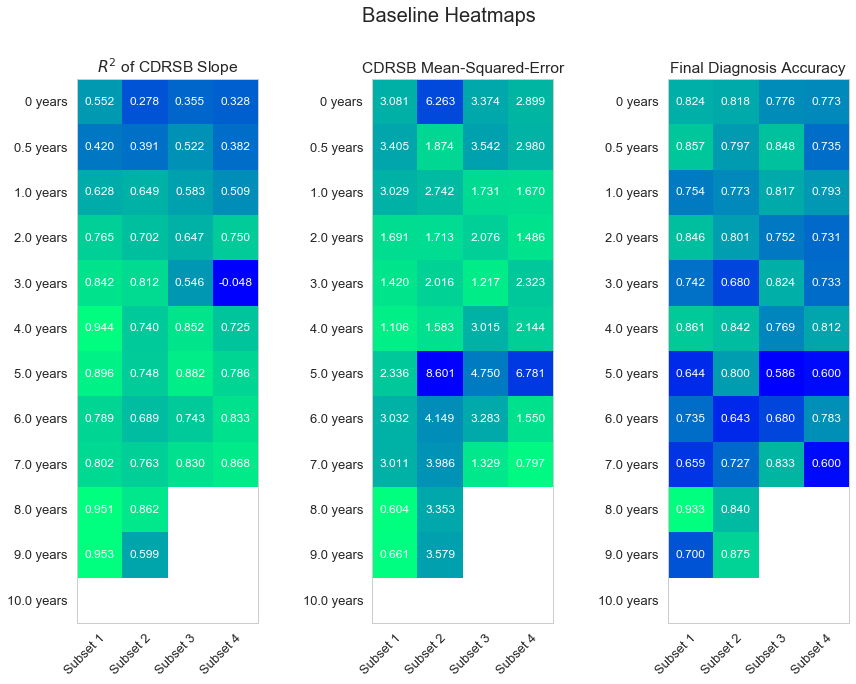

In [11]:
'''BASELINE HEATMAP'''

#Declare properties to map
cdrsb_error_mat = np.zeros((12,4))
R2_mat = np.zeros((12,4))
diagnosis_accuracy_mat = np.zeros((12,4))
years = [0,0.5]+list(np.linspace(1,10,10))

#Compute property matrices
for i in range(4):
    for j,y in enumerate(years):
        numNonFinalPatients = sum((assessments[i][y]['TIME'] - assessments[i][y]['final_time'])!=0)
        if numNonFinalPatients > 10:
            _,_,R2_mat[j][i],_,cdrsb_error_mat[j][i],\
            _,diagnosis_accuracy_mat[j][i]=\
            run_model(Xs[i][y],ys[i][y],assessments[i][y])
        else:
            cdrsb_error_mat[j][i] = np.NaN
            R2_mat[j][i] = np.NaN
            diagnosis_accuracy_mat[j][i] = np.NaN
            
#Plot heatmaps
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,10))
plotHeatMap(R2_mat,axes[0],'$R^2$ of CDRSB Slope')
plotHeatMap(cdrsb_error_mat,axes[1],'CDRSB Mean-Squared-Error',reverse=True)
plotHeatMap(diagnosis_accuracy_mat,axes[2],'Final Diagnosis Accuracy')
plt.suptitle('Baseline Heatmaps',fontsize=20);

The figure above plots heatmaps of the $3$ different model scores ($R^2$ of the overall CDRSB slope, MSE of the final CDRSB prediction, and accuracy of the final diagnosis prediction) as a function of the follow-up visit timing and feature subset selection. The color scale is set for each metric so that green is desirable.

We do not see any clear trends with the different predictor subsets. This might imply that we do not need to collect the more expensive metrics (e.g. imaging data from subset $3$).

Looking first at the $R^2$ score, we see an increase of performance over time. This is due to the fact that we are including an engineered feature (current CDRSB slope estimate) that asymptotically approaches our response variable (overall CDRSB slope) as time progresses.

For the subsequent plots (MSE of the final CDRSB predition and accuracy of the final diagnosis prediction), we observe a peak in performance when approximately $3-4$ years of data are included in the model. The reason behind this local maximum comes from the fact that we are attempting to extrapolate the progression of each patient forward in time to their final visit. Given our initial EDA, we hypothesize that this $3$ to $4$ year window corresponds to a peak in patients leaving the study. This would imply that for the majority of patients we are extrapolating on a very short timespan which would explain the higher accuracy.  We can investigate this in more details by looking at the histogram of the duration for which the patients remained in the study.

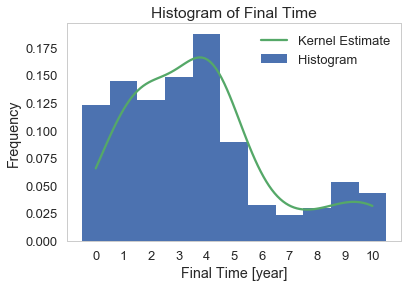

In [12]:
'''HISTOGRAM AND ESTIMATE KERNEL OF FINAL TIME'''

#Kernel density
kde = KernelDensity(kernel='gaussian', bandwidth=1.).fit(assessments[2][0.]['final_time'].values.reshape(-1,1))
t = np.linspace(0,10,100)
tt = np.exp(kde.score_samples(t.reshape(-1,1)))

#Plot hist. + kernel
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(assessments[0][0.]['final_time'],density=True,bins=range(12),align='left')
ax.set_xlabel('Final Time [year]')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Final Time');
ax.set_xticks(range(11))
ax.plot(t,tt,'-',label='Kernel Estimate')
ax.legend(['Kernel Estimate','Histogram']);
ax.grid(False);

As we can see here, there is in fact a peak around the $3$ to $4$ window which confirms our hypothesis. Thus, this explains the peak in the model prediction scores. We will explore different ways to eliminate this bias in the following section.

### Improving Baseline Model: Adding Sample Weight

In order to improve the performance of the baseline model, we have to account first for the high correlation between the response variable (overall CDRSB-slope) and our engineered predictor (current CDRSB-slope estimate thus far) when the patient is approaching his final visit. In fact, at the final visit, the engineered predictor will be exactly equal to the response variable. This will lead to massive over-fitting on the training set, over emphasizing the importance of the engineered predictor.

As discussed in the Introduction, one way to deal with this longitudinal correlation is to weight observations based on the duration for which each patient remained in the study. Therefore, we introduce sample weight to the random forest model. The array of sample weights are modeled as follows:

$$ w_i = \left(1 - \frac{t_i}{f_i}\right)^p,$$
 
where $w_i$ corresponds to the $i^{th}$ weight to apply to the train response variable, $t_i$ is the current time of the patient's visit, $f_i$ is the final time of the patient's history, and $p$ is a power. The sample weight varies from $0$ when $t_i = f_i$ to $1$ when $t_i = 0$. Therefore, the sample weight is decreased as time progresses, helping to counter act the increase correlation between the response variable and our engineered longitudinal feature. The exponent $p$ becomes an hyper-parameter that we will explore in a later section.

As discussed in the previous section, another problem we have to deal with is the discrepancy between when patients dropped out of the study. This is highlighted in the histogram above where we also overlay an estimated kernel density function.

To deal with this issue, we apply sample weight based on the kernel density estimate. To do this, we update our sample weight function to

$$ w_i = \frac{\left(1 - \frac{t_i}{f_i}\right)^p}{k(f_i)},$$

where $k(f_i)$ is the value of the kernel estimate varying with the final time of the $i^{th}$ observation in the dataframe. This introduces a new hyper-parameter $b$ corresponding to the bandwidth of the kernel density function.

These sample weight coefficients are implemented in the function $\texttt{run_model}$.

In [13]:
# '''HEATMAPS OF THE WEIGHTED MODELS'''

# #Declare properties to map
# cdrsb_error_mat = np.zeros((12,4))
# R2_mat = np.zeros((12,4))
# diagnosis_accuracy_mat = np.zeros((12,4))
# years = [0,0.5]+list(np.linspace(1,10,10))

# #Hyper-parameters
# p = 2
# b = .5

# #Compute property matrices
# for i in range(4):
#     for j,y in enumerate(years):
#         numNonFinalPatients = sum((assessments[i][y]['TIME'] - assessments[i][y]['final_time'])!=0)
#         if numNonFinalPatients > 10:
#             _,_,R2_mat[j][i],_,cdrsb_error_mat[j][i],\
#             _,diagnosis_accuracy_mat[j][i]=\
#             run_model(Xs[i][y],ys[i][y],assessments[i][y],weight=p,bandwidth=b,kernel_opt=True)
#         else:
#             cdrsb_error_mat[j][i] = np.NaN
#             R2_mat[j][i] = np.NaN
#             diagnosis_accuracy_mat[j][i] = np.NaN
            
# #Plot heatmaps
# fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,10))
# plotHeatMap(R2_mat,axes[0],'$R^2$ of CDRSB Slope')
# plotHeatMap(cdrsb_error_mat,axes[1],'CDRSB Mean-Squared-Error',reverse=True)
# plotHeatMap(diagnosis_accuracy_mat,axes[2],'Final Diagnosis Accuracy')
# plt.suptitle('Heatmaps of Weighted Models',fontsize=20);

### Improving Baseline Model: Hyper-Parameter Tuning

With Random Forest and our implemented sample weight coefficients, we now have now introduced a number of hyper-parameters that can be tuned to improve model performance. We will tune the following $4$ different hyper-parameters with the tested values in parentheses.

1. Random Forest Tree Maximum Depth (3,5,10,20)
2. Weight Power (0,1,2,3)
3. Kernel Estimate Bandwidth (0.25,0.5,0.75)
4. Random Forest Number of Trees (10,50,100)

To perform the hyper-parameter tuning, we have implemented the function $\texttt{GridSearch}$.

In [14]:
'''HYPER-PARAMETERS TUNING'''

#Declare bound of hp
max_depths = [3,5,10,20]
weights = [0,1,2,3]
bandwidths = [0.25, 0.5, 0.75]
n_estimators = [10,50,100]

#Declare outputs of the search
best_cdrsb_error = defaultdict(dict)
best_diagnosis_accuracy = defaultdict(dict)
best_R2 = defaultdict(dict)
best_params = defaultdict(dict)

#Number of years of the study
years = [0,0.5]+list(np.linspace(1,10,10))

#Perform grid search
# t0 = clock()
# for subset in range(4):
#     for y in years:
#         numNonFinalPatients = sum((assessments[subset][y]['TIME'] - assessments[subset][y]['final_time'])!=0)
#         if  numNonFinalPatients > 10:
#             best_cdrsb_error[subset][y], best_diagnosis_accuracy[subset][y], \
#             best_R2[subset][y], best_params[subset][y] = \
#             GridSearch(max_depths,weights,bandwidths,n_estimators,subset,y)
#             print((subset,y,clock()-t0,'Successful'))
#         else:
#             best_cdrsb_error[subset][y] = np.NaN
#             best_diagnosis_accuracy[subset][y] = np.NaN
#             best_R2[subset][y] = np.NaN
#             best_params[subset][y] = np.NaN
#             print((subset,y,clock()-t0,'Too few people'))

In [15]:
'''SAVE ENVIRONMENT'''

#Grid search is long so we save results ...
# import pickle
# with open('grid_search.pkl','wb') as f:
#     pickle.dump([best_cdrsb_error,best_diagnosis_accuracy,best_R2,best_params],f)

'SAVE ENVIRONMENT'

In [16]:
'''LOAD ENVIRONMENT'''
import pickle
with open('grid_search.pkl','rb') as f:
    best_cdrsb_error,best_diagnosis_accuracy,best_R2,best_params =pickle.load(f)


We can plot the heatmaps of the model performance for tuned hyper-parameters.

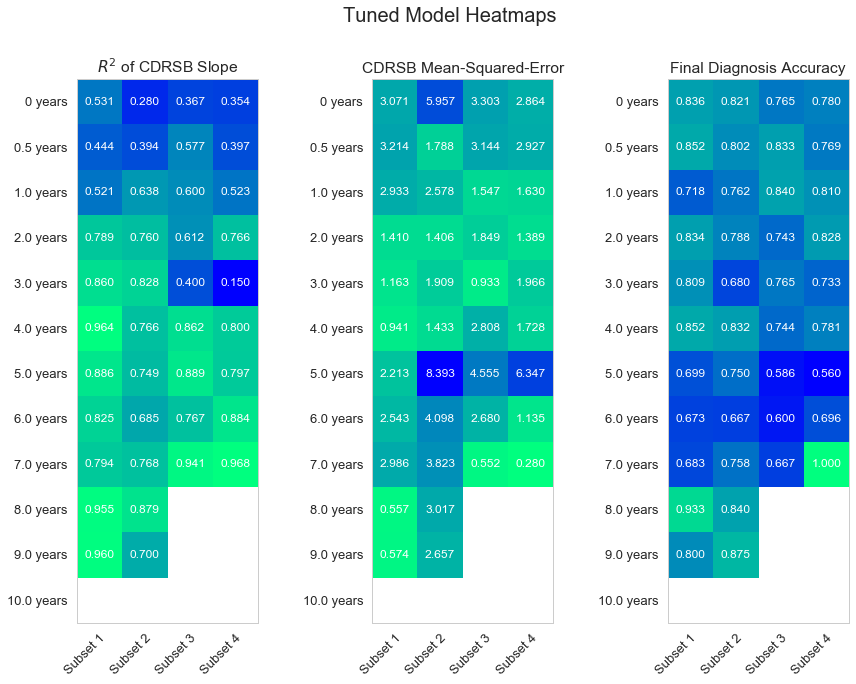

In [17]:
'''HEATMAPS OF THE TUNED MODELS'''

#Declare properties to map
cdrsb_error_mat = np.zeros((12,4))
R2_mat = np.zeros((12,4))
diagnosis_accuracy_mat = np.zeros((12,4))

#Compute property matrices
for i in range(4):
    for j,y in enumerate(years):
        cdrsb_error_mat[j,i] = best_cdrsb_error[i][y]
        R2_mat[j,i] = best_R2[i][y]
        diagnosis_accuracy_mat[j,i] = best_diagnosis_accuracy[i][y]

#Plot heatmaps
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,10))
plotHeatMap(R2_mat,axes[0],'$R^2$ of CDRSB Slope')
plotHeatMap(cdrsb_error_mat,axes[1],'CDRSB Mean-Squared-Error',reverse=True)
plotHeatMap(diagnosis_accuracy_mat,axes[2],'Final Diagnosis Accuracy')
plt.suptitle('Tuned Model Heatmaps',fontsize=20);

As we can see from the heatmaps of the models with tuned hyper-parameters, we have reduced the peak in the MSE of the CDRSB score prediction and the final diagnosis prediction accuracy. This indicates that our weighting coefficients have helped compensate for the bias in our dataset. Furthermore, based on a coarse hyper-parameter tuning, we were able to slightly improve our prediction results.

From the heatmaps of the tuned models, we can identify one of the most promissing models with respect to final diagnosis accuracy. While this model only uses data from a single $6$-month follow-up visit and the most minimal subset of predictors, it is still associated with $85.2$% accuracy on the prediciton of the diagnosis. Thus, it presents evident appeal to the medical community given its low cost and potential for early detection.

For this particular model, we examine the feature importance in the figure below.

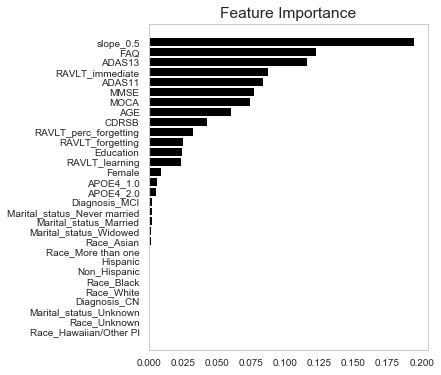

In [18]:
'''FEATURE IMPORTANCES'''
   
#Run model based on best hyper-parameters
y_best = 0.5
s_best = 0
best_model,_,_,_,_,_,_,=\
run_model(Xs[s_best][y_best],ys[s_best][y_best],\
          assessments[s_best][y_best],max_depth=best_params[s_best][y_best][0],\
         weight=best_params[s_best][y_best][1],\
         kernel_opt=True,n_estimators=best_params[s_best][y_best][3])

#Plot feature importance on hbar
f_imp = best_model.feature_importances_
f_name = Xs[s_best][y_best].columns.values
f_imp,f_name = zip(*sorted(zip(f_imp,f_name)))
plt.figure(figsize=(5,6))
plt.barh(f_name,f_imp,color='k')
plt.grid(False)
plt.tick_params(labelsize=10)
plt.title('Feature Importance');

As expected, the most important feature is the slope estimate thus far after $0.5$ year. Similarly to the correlation result in the EDA, we see that FAQ is an important feature in predicting final diagnosis. At the other end of the spectrum, race and marital status are not important features in the model. In addition, interestingly the current diagnosis is not important to predicting future disease progression. This indicates that knowing one's current disease status along does not tell how a patient will progress over time.

### Exploration of Model Misclassification Rates

Finally, we want to investigate the number of false positives/negatives in our final diagnosis predictions to better understand the types of errors that our model makes. Thus, we generate a confusion matrix of the best-performing model evaluated on the test set.

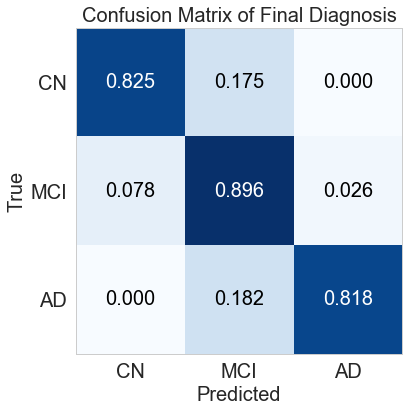

In [64]:
'''PLOT CONFUSION MATRIX OF FINAL DIAGNOSIS PREDICTIONS'''

# Generate final diagnosis predictions
X = Xs[s_best][y_best]
y = ys[s_best][y_best]
assessment = assessments[s_best][y_best]
_, X_test, _, y_test, _, assessment_test = train_test_split(X, y, assessment, test_size=0.3, random_state=40,\
                                        stratify=X[['Diagnosis_CN','Diagnosis_MCI']])
cdrsb_pred_test  = \
    [i+s*t for i,s,t in zip(assessment_test['base_cdrsb'],best_model.predict(X_test),assessment_test['final_time'])]
diagnosis_pred_test = ['CN' if i  <0.5 else 'MCI' if i < 4. else 'AD' for i in cdrsb_pred_test]


# Generate and plot confusion matrix
cm = confusion_matrix(assessment_test['final_diagnosis'],diagnosis_pred_test,labels=['CN','MCI','AD'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm,cmap=plt.get_cmap('Blues'))
plt.grid(False)
for i in range(3):
    for j in range(3):
        if i==j:
            col = 'w'
        else:
            col = 'k'
        plt.text(i, j, "{:0.3f}".format(cm[j,i]),
                           ha="center", va="center", color=col,fontsize=20)
plt.xticks([0,1,2],['CN','MCI','AD'],fontsize=20)
plt.yticks([0,1,2],['CN','MCI','AD'],fontsize=20)
plt.title('Confusion Matrix of Final Diagnosis',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('True',fontsize=20);

As we can see from the above table, the model generally performs very similarly across the three classes of data, exhibiting ~$82$% to ~$90$% accuracy on each of the diagnoses. In medical studies, one must take special care to minimize the rate of false negatives, since this results in patients not receiving the proper care they need. We see that our model never misclassified patients who actually had AD as CN, or vice versa. There were some false positives/negatives involving the MCI diagnosis (in particular, the model seems to be over-predicting MCI across all three classes), however, this is less of a severe issue than confusing CN and AD. The most obvious area for improvement highlighed in this table is the $18.2$% false negative rate where AD patients were incorrectly classified as MCI. 